In [1]:
# Librerias

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score,make_scorer
from sklearn.cluster import AgglomerativeClustering, KMeans, MeanShift
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE

**Recopilación de un conjunto diverso de imágenes en diferentes estilos artísticos, a partir del repositorio.**

In [4]:
# Funcion para Cargar la imagen
def load_image(image_path):
    """
    # Carga una imagen cuyo path se ingresa por parametro
    # image_path: String
    #            Ruta a la imagen a cargar
    """
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

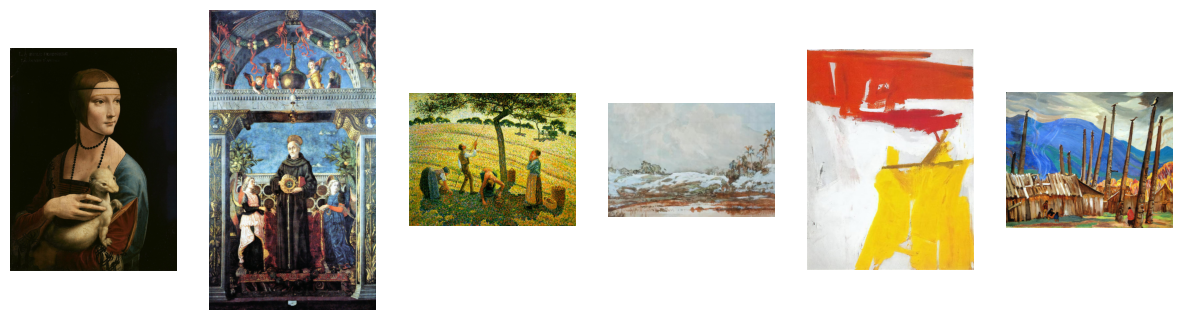

In [6]:
def show_selected_images():
    fig, ax = plt.subplots(1,6,figsize=(15, 13)) 
    for i in range(0,6):
        path = f'img/img{i}.jpg'
        raw_image = load_image(path)
        ax[i].imshow(raw_image)
        ax[i].axis('off')

show_selected_images()

**Preparación de los datos, justificando las decisiones tomadas.**

Se define la clase encargada de realizar el pre procesamiento de la imagen con el fin de disminuir el tamaño de la misma y aun mas importante convertirla en un arreglo de 2 dimensiones con valores entre 0 y 1, esto se logra dividiendo cada uno de los valores en 255, el cual es el valor maximo del codigo RGB

In [9]:
# Pre-procesamiento de la imagen:  
class image_processing(BaseEstimator, TransformerMixin):
    
    def __init__(self, factor=0.5, show=False):
        self.factor = factor
        self.show = show
        self.img_final = None
        
    def fit(self, X, y=None):
        # No se necesita ajuste para el preprocesamiento, solo se implementa para que el pipeline la acepte
        return self
    
    def transform(self, X, y=None):
        # Preprocesamiento de la imagen
        nuevo_ancho = int(X.shape[1] * self.factor)
        nuevo_alto = int(X.shape[0] * self.factor)
        nuevo_tamanio = (nuevo_ancho, nuevo_alto)
        
        img_submuestreada = cv2.resize(X, nuevo_tamanio)
        #img_submuestreada = cv2.cvtColor(img_submuestreada, cv2.COLOR_RGB2LAB)  # Conversión a CIELAB
        
        if self.show:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title(f'Imagen Original: {X.shape}')
            plt.imshow(X)
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.title(f'Imagen submuestreada: {img_submuestreada.shape}')
            plt.imshow(img_submuestreada)
            plt.axis('off')
        
        # Darle formato a la imagen (reducción a un array 2D de características)
        img_final = img_submuestreada.reshape((-1, 3)) / 255
        self.img_final = img_final
        
        return self.img_final

***Construcción de la función que transforma los grupos de colores identificados en un muestrario representativo***

In [12]:
#Funcion para obtener la paleta de colores de una imagen especifica
def plotColorPallete(raw_image, colors):
    
    colors = np.clip(colors, 0, 1) 
    # Mostrar la imagen original junto con su paleta de colores
    fig, ax = plt.subplots(1,2,figsize=(5, 3))  
    
    ax[0].imshow(raw_image)
    ax[0].set_title('Imagen Original')
    ax[0].axis('off')
    
    # crear la paleta
    for i, color in enumerate(colors):
        ax[1].bar(i, height=1, color=color, edgecolor='none', width=1)
    
    ax[1].set_title('Paleta de Colores')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

**Construcción de los diferentes modelos**

***DBSCAN***

***MeanShift***

In [17]:
# Funcion de busqueda de hiperparamentros
class getMeanShiftClustering(BaseEstimator, TransformerMixin):
    
    def __init__(self, params=None, n_init=10, n_splits=5, random_state=0, n_jobs=-1, metric = silhouette_score):
        self.params = params if params else {'bandwidth': [0.08, 0.1,0.13]}
        self.n_init = n_init
        self.n_splits = n_splits
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.metric = metric
        self.best_bandwidth = None
        self.silhouette_scores = None
        self.cluster_labels = None
    
    def score_fn(self, modelo, data):
        self.cluster_labels = modelo.fit_predict(data)
        score = silhouette_score(data, self.cluster_labels)
        return score

    def silhouette_plot(self, ax =None):
        scores = self.silhouette_scores
        ax.plot(self.params['bandwidth'], scores, marker='o')
        ax.set_xlabel('Bandwidth')
        ax.set_ylabel('Silhouette Score')
        ax.grid()

    def t_sne_plot(self, img_processed, ax=None):
        tsne = TSNE(n_components = 2,random_state=0)
        tsne_transformed = tsne.fit_transform(img_processed)  # Reducción a 2D
        # Obtener etiquetas de clusters
        cluster_labels = self.transform(img_processed)
        x_tsne = pd.DataFrame(tsne_transformed, columns=['Dimension 1', 'Dimension 2'])
        K = len(cluster_labels)
        
        # Visualización
        MARKER = ['o', 'v', '1']

        ax.set_xlabel('Representación en dos dimensiones')
        for i in range(K):
            selections = x_tsne[cluster_labels == i]
            ax.scatter(selections['Dimension 1'], selections['Dimension 2'], alpha=0.8, marker=MARKER[i % len(MARKER)], s=5)
            x_mean, y_mean = selections.mean(axis=0)
            ax.text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 20})

    def fit(self, X, y=None):
        #------
        #Nota: los hiperparametros Quantile y n_samples tienen una afectacion directa en
        #la paleta resultante, los mejor seria desarrollar una grilla con posibles valores
        #de estos hiperparametros y seleccionar la mejor dupla, basandonos en metricas de
        # agrupacion
        #bandwidth = estimate_bandwidth(img_final_pca, quantile=0.09, n_samples=50)
        meanshift = MeanShift(bin_seeding=True, cluster_all = False)
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        grid = GridSearchCV(meanshift, self.params, cv=kfold, scoring=self.score_fn, n_jobs=self.n_jobs)
        grid.fit(X)
        self.silhouette_scores = grid.cv_results_['mean_test_score']
        self.best_bandwidth = grid.best_params_['bandwidth']
        self.best_model_ = grid.best_estimator_
        
        #------
        return self

    def transform(self, X):
        if self.best_model_ is None:
            raise RuntimeError("Fit debe ser llamado  ya que no se ha ajustado el modelo aun.")
        return self.best_model_.fit_predict(X)

In [19]:
#Construccion del pipeline para Kmeans
def getMeanShiftPipeline():
    return Pipeline(steps=[('preprocessing',image_processing(factor = 0.1)),                           
                           ('clustering', getMeanShiftClustering())             
                           ])

In [25]:
def getMeanShiftColorPallete(img_path): 
    #Cargar la imagen
    raw_image = load_image(img_path)
    # Implementacion del Pipeline
    
    pipe = getMeanShiftPipeline()
    
    pipe.fit(raw_image)
    
    colors = pipe.named_steps['clustering'].best_model_.cluster_centers_
    print(f'La ruta de la imagen es :{img_path}')
    bandwidth = pipe.named_steps['clustering'].best_bandwidth
    print(f'El bandwidth es: {bandwidth}')
    print(f'El Numero de clusters encontrado es: {len(colors)}')
    
    # Crear Paleta de colores     
    plotColorPallete(raw_image,colors)
    
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].set_title('Metodo de la silueta')
    pipe.named_steps['clustering'].silhouette_plot(axarr[0])
    
    #axarr[1].set_title('T-SNE')
    #pipe.named_steps['clustering'].t_sne_plot(pipe.named_steps['preprocessing'].img_final, axarr[1])
    plt.show()
    
    return pipe,raw_image

La ruta de la imagen es :img/img1.jpg
El bandwidth es: 0.13
El Numero de clusters encontrado es: 5


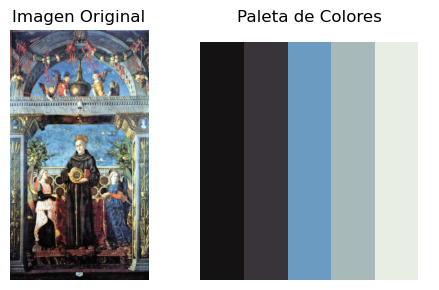

<Figure size 640x480 with 0 Axes>

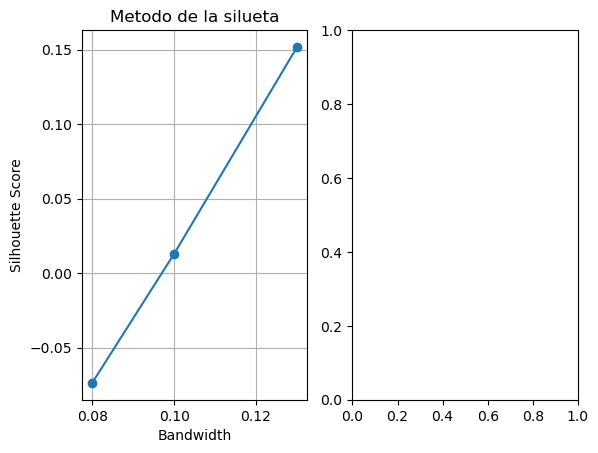

In [27]:
meanShiftPipe,img = getMeanShiftColorPallete('img/img1.jpg')

***Kmeans***

In [18]:
# Funcion de busqueda de hiperparamentros
class getKmeansClustering(BaseEstimator, TransformerMixin):
    
    def __init__(self, params=None, n_init=10, n_splits=5, random_state=0, n_jobs=-1, metric = silhouette_score):
        self.params = params if params else {'n_clusters': [5 ,6 ,7]}
        self.n_init = n_init
        self.n_splits = n_splits
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.metric = metric
        self.best_k = None
        self.silhouette_scores = None
        self.cluster_labels = None
    
    def score_fn(self, modelo, data):
        self.cluster_labels = modelo.fit_predict(data)
        score = silhouette_score(data, self.cluster_labels)
        return score

    def silhouette_plot(self, ax =None):
        scores = self.silhouette_scores
        ax.plot(self.params['n_clusters'], scores, marker='o')
        ax.set_xlabel('Número de clústeres')
        ax.set_ylabel('Silhouette Score')
        ax.grid()

    def t_sne_plot(self, img_processed, ax=None):
        tsne = TSNE(n_components = 2,random_state=0)
        tsne_transformed = tsne.fit_transform(img_processed)  # Reducción a 2D
        # Obtener etiquetas de clusters
        #cluster_labels = self.cluster_labels
        cluster_labels = self.transform(img_processed)
        x_tsne = pd.DataFrame(tsne_transformed, columns=['Dimension 1', 'Dimension 2'])
        K = self.best_k
        
        # Visualización
        MARKER = ['o', 'v', '1']

        ax.set_xlabel('Representación en dos dimensiones')
        for i in range(K):
            selections = x_tsne[cluster_labels == i]
            ax.scatter(selections['Dimension 1'], selections['Dimension 2'], alpha=0.8, marker=MARKER[i % len(MARKER)], s=5)
            x_mean, y_mean = selections.mean(axis=0)
            ax.text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 20})

    def fit(self, X, y=None):
        KM = KMeans(n_init=self.n_init)
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        grid = GridSearchCV(KM, self.params, cv=kfold, scoring=self.score_fn, n_jobs=self.n_jobs)
        grid.fit(X)
        self.silhouette_scores = grid.cv_results_['mean_test_score']
        self.best_k = grid.best_params_['n_clusters']
        self.best_model_ = grid.best_estimator_
        return self

    def transform(self, X):
        if self.best_model_ is None:
            raise RuntimeError("Fit debe ser llamado  ya que no se ha ajustado el modelo aun.")
        return self.best_model_.fit_predict(X)

In [20]:
#Construccion del pipeline para Kmeans
def getKmeansPipeline():
    return Pipeline(steps=[('preprocessing',image_processing(factor = 0.1)),                           
                           ('clustering', getKmeansClustering())             
                           ])

In [22]:
def getKmeansColorPallete(img_path): 
    #Cargar la imagen
    raw_image = load_image(img_path)
    # Implementacion del Pipeline
    
    pipe = getKmeansPipeline()
    
    pipe.fit(raw_image)
    
    colors = pipe.named_steps['clustering'].best_model_.cluster_centers_
    print(f'La ruta de la imagen es :{img_path}')
    K = pipe.named_steps['clustering'].best_k
    print(f'El mejor numero de clusters K es: {K}')
    
    # Crear Paleta de colores     
    plotColorPallete(raw_image,colors)
    
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].set_title('Metodo de la silueta')
    pipe.named_steps['clustering'].silhouette_plot(axarr[0])
    
    axarr[1].set_title('T-SNE')
    pipe.named_steps['clustering'].t_sne_plot(pipe.named_steps['preprocessing'].img_final, axarr[1])
    plt.show()
    
    return pipe,raw_image

La ruta de la imagen es :img/img1.jpg
El mejor numero de clusters K es: 5


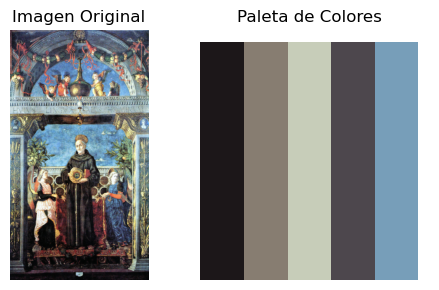

<Figure size 640x480 with 0 Axes>

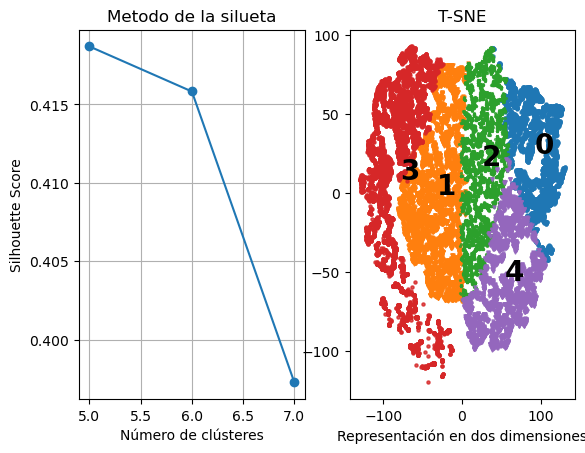

In [26]:
kmeansPipe,img = getKmeansColorPallete('img/img1.jpg')

**Resultado y Conclusiones**